## Physics-informed neural networks (PINNs) - ODE

In the following notebook we will showcase a formulation capable of approximating the solution of ODEs using PINNs.

In [1]:
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

### Example

The **damped harmonic oscillator** will be solved using PINNs. The displacement, $u(t)$, of the oscillator as a function of time can be described by the following ODE:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction. 

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~ 
$$


In [2]:
### Exact solution ###

def oscillator(m, mu, k, t):
    delta = mu/(2*m)
    w0 = np.sqrt(k/m)
    
    assert delta < w0
    w = np.sqrt(w0**2-delta**2)
    phi = np.arctan(-delta/w)
    A = 1/(2*np.cos(phi))

    u = np.exp(-delta*t)*(2*A*np.cos(phi+w*t))
    return u
    

In [3]:
### Neural Network ###

class Model(nn.Module):
    def __init__(self, in_features, out_features, hidden_layer_sizes):
        super().__init__()
        layers = []
        # Adding input layer to the first hidden layer
        layers.append(nn.Linear(in_features, hidden_layer_sizes[0]))
        layers.append(nn.Tanh())  # Tanh activation function for this type of network is used
        # Adding hidden layers
        for i in range(len(hidden_layer_sizes) - 1):
            layers.append(nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]))
            layers.append(nn.Tanh())  
        # Adding output layer
        layers.append(nn.Linear(hidden_layer_sizes[-1], out_features))
        
        # Combining all layers into a Sequential module
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

#### Approach

The Physics-Informed Neural Network (PINN) is utilized to directly approximate the solution to the given differential equation, denoted as:

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ represents the trainable parameters of the PINN.

##### Loss function

To emulate the behavior of the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

Here, $m = 1.5$, $\mu = 5$ and $k = 235$, and the aim is to capture the solution over the interval $t\in [0,1]$.

**Notes**

The initial two terms in the loss function correspond to the **boundary loss**, ensuring that the PINN solution aligns with the initial conditions of the system, specifically $u(t=0)=1$ and $u'(t=0)=0$.

The third term in the loss function represents the **physics loss**, ensuring that the PINN solution adheres to the underlying differential equation at a designated set of training points $\{t_i\}$ distributed across the entire domain.

Hyperparameters $\lambda_1$ and $\lambda_2$ are introduced to regulate the terms in the loss function, facilitating stability during the training process.

In [4]:
### Loss function ### 

def loss(model, t_bound, t_points, m, mu, k):
    # compute each term of the PINN loss function above
    
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-4

    # Boundary losses
    u_b = model(t_bound)
    l1 = (torch.squeeze(u_b) - 1)**2 

    dudt_b = torch.autograd.grad(u_b, t_bound, torch.ones_like(u_b), create_graph=True)[0]
    l2 = (torch.squeeze(dudt_b) - 0)**2

    # ODE loss
    u_p = model(t_points)
    dudt_p = torch.autograd.grad(u_p, t_points, torch.ones_like(u_p), create_graph=True)[0]
    d2udt2_p = torch.autograd.grad(dudt_p, t_points, torch.ones_like(dudt_p), create_graph=True)[0]
    l3 = torch.mean((m*d2udt2_p + mu*dudt_p + k*u_p)**2)

    total_loss = l1 + lambda1*l2 + lambda2*l3
    return total_loss

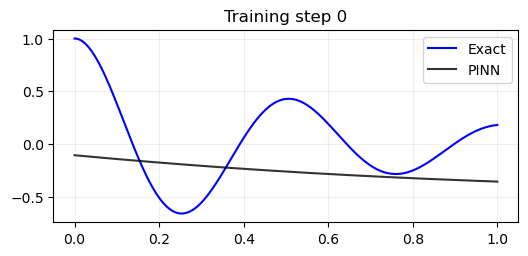

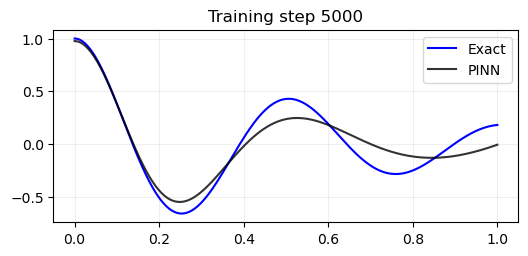

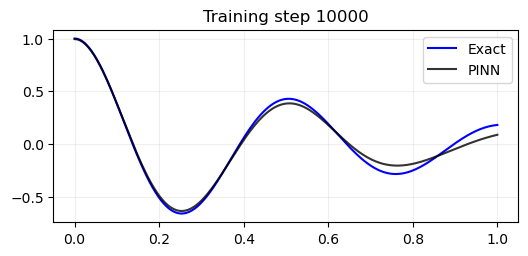

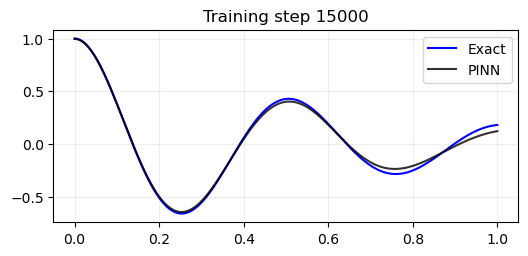

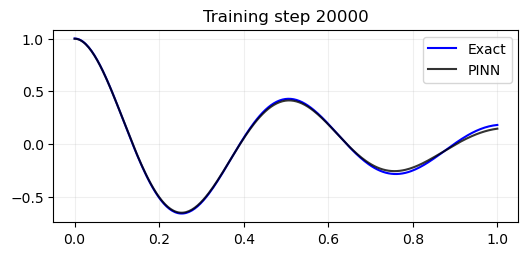

In [5]:
### Training ###
torch.manual_seed(123)

## Model ##
# Define input and output sizes
in_features = 1
out_features = 1 

# Define list of hidden layer sizes
hidden_layer_sizes = [64]  

pinn = Model(in_features, out_features, hidden_layer_sizes)


## Points for boundary and physical losses ##
t_bounds = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_points = torch.linspace(0,1,30).view(-1,1).requires_grad_(True) # Amount of points is variable, more points more accurate


## Training loop ##

mass = 1.5
mu = 5
k = 235

optimizer = torch.optim.Adam(pinn.parameters(),lr=1e-3)

t_test = np.linspace(0,1,300)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32).view(-1, 1)
u_exact = oscillator(mass, mu, k, t_test)

for i in range(int(20e3)+1):
    optimizer.zero_grad()

    loss_val = loss(pinn, t_bounds, t_points, mass, mu, k)
    loss_val.backward()
    optimizer.step()


    if i % 5000 == 0: 
        plt.figure(figsize=(6,2.5))
        u_pinn = pinn(t_test_tensor).detach().numpy()
        plt.plot(t_test, u_exact, color="blue", label="Exact")
        plt.plot(t_test, u_pinn, color="black", alpha=0.8, label="PINN")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.grid(alpha=0.2)

        plt.show()
